In [1]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os, sys
import pickle
from collections import defaultdict
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms
import torchvision.transforms as transforms
from torch.autograd import Variable
from sklearn.metrics import roc_auc_score
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler
import time
import copy
import cv2 as cv

os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [2]:
model_filename = 'resnet_0216.pt'

In [3]:
data_transforms = {
    'train': transforms.Compose([
        ##transforms.ToPILImage(),
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        
        transforms.RandomRotation(10)
        
    ]),
    
    'val': transforms.Compose([
        ##transforms.ToPILImage(),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    ]),
}

In [4]:
data_dir = "../datasets/test"
#data_dir = "F:/python/Competition_No1/datasets/test"


image_datasets = datasets.ImageFolder(data_dir, data_transforms['val'])

# path['train']는 train set의 경로
# path['test']는 val set의 경로

dataloaders = torch.utils.data.DataLoader(image_datasets, batch_size=2, shuffle=False, num_workers=0)

dataset_sizes = len(image_datasets) 
class_names = image_datasets.classes


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



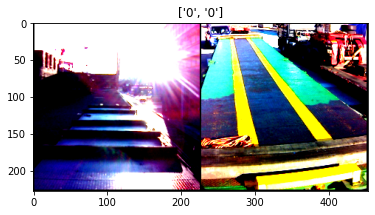

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))

    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 갱신이 될 때까지 잠시 기다립니다.


# 한개의 Bathc만큼 이미지를 불러온다. 배치사이를 4로 헀으니 4장이 로드된다. 
inputs, classes = next(iter(dataloaders))

# 배치로부터 격자 형태의 이미지를 만듭니다.
out = torchvision.utils.make_grid(inputs)

# 이미지를 출력한다. 
imshow(out, title=[class_names[x] for x in classes])


In [6]:
#model_filename = 'resnet_train_resize_0217.pt'

#model_ft = torch.load("F:/python/Competition_No1/code/model/resnet_addResize2_0217.pt")
model_ft = torch.load('./model/' + model_filename)

In [7]:
def compute_AUCs(gt, pred):
    AUROCs = []

    gt_np = gt.cpu().numpy()
    pred_np = pred.cpu().numpy()
    AUROCs = roc_auc_score(gt_np, pred_np)
    return AUROCs

In [8]:
model = model_ft

since = time.time() #시작 시간을 기록(총 소요 시간 계산을 위해)

train_acc = []
val_acc = []
train_auc = []
val_auc = []

best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
best_auc = 0.0

model.eval()   # Set model to evaluate mode

running_corrects = 0

gt = torch.FloatTensor()
gt = gt.cuda()

pred = torch.FloatTensor()
pred = pred.cuda()

pred_auc = torch.FloatTensor()
pred_auc = pred_auc.cuda()

fileList = []

for i in dataloaders.dataset.imgs:
    fileList.append(i[0].split('\\')[-1])


# Iterate over data.
for inputs, labels in dataloaders: #dataloader로부터 dataset과 그에 해당되는 label을 불러옴
    
#     # 배치로부터 격자 형태의 이미지를 만듭니다.
#     out = torchvision.utils.make_grid(inputs)

#     # 이미지를 출력한다. 
#     imshow(out, title=[class_names[x] for x in labels])
    
    

    
    inputs = inputs.to(device) #GPU로 입력데이터를 올림
    labels = labels.to(device) #GPU로 label을 올림

    with torch.no_grad():
        outputs = model(inputs)
        m = nn.Softmax(dim=1)
        preds = m(outputs)[:,1]
        _, preds_max = torch.max(outputs, 1)
        gt = torch.cat((gt, labels), 0)
        pred = torch.cat((pred, preds_max), 0)
        pred_auc = torch.cat((pred_auc, preds), 0)

    running_corrects += torch.sum(preds_max == labels.data)
    


epoch_acc = running_corrects.double() / dataset_sizes
epoch_auc = compute_AUCs(gt, pred)
val_acc.append(epoch_acc)
val_auc.append(epoch_auc)

print('val\t Acc: {:.4f}'.format(epoch_acc))

print("val\t AUC: " + str(round(epoch_auc,4)))


time_elapsed = time.time() - since
print('complete in {:.3f} ms/image'.format(time_elapsed * 1000 / dataset_sizes))
print()

## 그냥 마지막 모델을 사용
best_model_wts = copy.deepcopy(model.state_dict())

# load best model weights
model.load_state_dict(best_model_wts)

val	 Acc: 0.8500
val	 AUC: 0.85
complete in 199.033 ms/image



<All keys matched successfully>

In [9]:
total_true = 0

log = open(f'./result.txt', 'w')
head = f'{"Image lst"}\t{"GT"}\t{"Prediction"}\taccuracy'
print(head)
log.write(f'{head}\n')
for i in range(len(fileList)):
    if gt[i] == pred[i]:
        accuracy = "True"
        total_true += 1
    else:
        accuracy = "False"
    
    log.write(f'{fileList[i]}\t{int(gt[i])}\t{int(pred[i])}\t{accuracy}\n')
    print(f'{fileList[i]}\t{int(gt[i])}\t{int(pred[i])}\t{accuracy}')
    
    
log.write(f'Average Accuracy\t{total_true/len(gt)*100:.2f}%\n')
log.write(f'Inference Speed (ms)\t{(time_elapsed * 1000 / dataset_sizes):.2f}ms/image\n')
print(f'Average Accuracy\t{total_true/len(gt)*100:.2f}%')
print(f'Inference Speed (ms)\t{(time_elapsed * 1000 / dataset_sizes):.2f}ms/image')

log.close()
file = pd.read_csv('./result.txt', delimiter='\t')
file.to_csv('./result.csv', index=False)


Image lst	GT	Prediction	accuracy
empty_V1.jpg	0	0	True
empty_V10.jpg	0	1	False
empty_V2.jpg	0	0	True
empty_V3.jpg	0	0	True
empty_V4.jpg	0	0	True
empty_V5.jpg	0	0	True
empty_V6.jpg	0	1	False
empty_V7.jpg	0	1	False
empty_V8.jpg	0	0	True
empty_V9.jpg	0	0	True
loaded_V1.jpg	1	1	True
loaded_V10.jpg	1	1	True
loaded_V2.jpg	1	1	True
loaded_V3.jpg	1	1	True
loaded_V4.jpg	1	1	True
loaded_V5.jpg	1	1	True
loaded_V6.jpg	1	1	True
loaded_V7.jpg	1	1	True
loaded_V8.jpg	1	1	True
loaded_V9.jpg	1	1	True
Average Accuracy	85.00%
Inference Speed (ms)	199.03ms/image
